In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt

# Reading the Data

## Feature Data

In [2]:
# Data file names
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

#There are mov files for different datas, I'll add all of them here latter 
movs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_GRELHA E EIXOS")
movs_2022_09 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv")
movs_2022_10 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv")
movs_2022_11 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv")

# Read data of each month
df_movs_2022_09= pd.read_csv(movs_2022_09, parse_dates=["Datetime"])
df_movs_2022_10= pd.read_csv(movs_2022_10, parse_dates=["Datetime"])
df_movs_2022_11= pd.read_csv(movs_2022_11, parse_dates=["Datetime"])

# Join the 3 months' dataframes:
df_movs = pd.concat([df_movs_2022_09, df_movs_2022_10, df_movs_2022_11])
del(df_movs_2022_09, df_movs_2022_10, df_movs_2022_11)

## Grid Info Data

In [3]:
# Read data from the xlsx file
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
grid_geometry = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

In [4]:
# Function to remove extra curly braces and return a valid WKT string
def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

In [5]:
# Remove extra curly braces
grid_geometry["wkt"] = grid_geometry["wkt"].apply(fix_wkt_string)

In [6]:
grid_geometry['geometry'] = grid_geometry['wkt'].apply(wkt.loads)

In [7]:
grid_gdf = gpd.GeoDataFrame(grid_geometry, geometry='geometry')

In [8]:
# create a dictionary of column name mappings
column_names = {'grelha_id': 'Grid_ID'}

# rename the grid_id column name using the dictionary
grid_gdf = grid_gdf.rename(columns=column_names)

# Analysis of the Missing Values

In [9]:
# count missing values in each column
print(df_movs.isna().sum())

Grid_ID     0
Datetime    0
C1          0
C2          0
C3          0
C4          0
C5          0
C6          0
C7          0
C8          0
dtype: int64


No missing values.

# Analysis of the Distribution of the Values

In [10]:

# describe the dataframe and store the result in a variable
desc = df_movs.describe(percentiles=[.25, .5, .75, .90, .95, .99])

# format the floating-point numbers using the apply method
desc = desc.apply(lambda x: x.apply(lambda y: format(y, '.2f') if isinstance(y, float) else y))

# exclude column 'Grid_ID' from the summary statistics
desc = desc.drop('Grid_ID', axis=1)

# format the summary statistics as a table
table = tabulate(desc, headers=desc.columns, tablefmt='fancy_grid')

print(table)

╒═══════╤══════════════════╤════════════════╤══════════════════╤════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╕
│       │               C1 │             C2 │               C3 │             C4 │              C5 │              C6 │             C7 │             C8 │
╞═══════╪══════════════════╪════════════════╪══════════════════╪════════════════╪═════════════════╪═════════════════╪════════════════╪════════════════╡
│ count │      3.08813e+07 │    3.08813e+07 │      3.08813e+07 │    3.08813e+07 │     3.08813e+07 │     3.08813e+07 │    3.08813e+07 │    3.08813e+07 │
├───────┼──────────────────┼────────────────┼──────────────────┼────────────────┼─────────────────┼─────────────────┼────────────────┼────────────────┤
│ mean  │    169.75        │   23.75        │    140.43        │   19.8         │    59.81        │    71.05        │    8.52        │    8.39        │
├───────┼──────────────────┼────────────────┼──────────────────┼────────────────┼───────

It seems that the max values are considerably larger than the 99th percentile, possibly indicating that the max values are anomalies.

In [3]:
# Add columns for hour, day, and month
df_movs['Hour'] = df_movs['Datetime'].dt.hour
df_movs['Day'] = df_movs['Datetime'].dt.day
df_movs['Month'] = df_movs['Datetime'].dt.month
df_movs['Weekday'] = df_movs['Datetime'].dt.weekday

Here is what our current data frame looks like:

In [4]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Day,Month,Weekday
0,1,2022-09-07 12:30:00+00:00,3.69,0.0,3.69,0.0,0.00,5.28,0.0,0.00,12,7,9,2
1,1,2022-09-07 22:30:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,22,7,9,2
2,1,2022-09-07 23:00:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,23,7,9,2
3,1,2022-09-07 18:00:00+00:00,15.72,0.0,10.48,0.0,5.24,6.84,0.0,2.45,18,7,9,2
4,1,2022-09-07 06:30:00+00:00,3.86,0.0,1.93,0.0,3.86,4.43,0.0,0.00,6,7,9,2


Let's have a broader view of the distribution of the values. For that, let's plot some histograms wich will show the average and the sums of values per day (disregarding location) for each feature.

In [14]:
# Group by time units (Hour, Day, Month, Weekday) and calculate mean/sum values for each feature
# hourly_mean = df_movs.groupby(['Grid_ID', 'Hour']).mean().reset_index()
# monthly_mean = df_movs.groupby(['Grid_ID', 'Month']).mean().reset_index()
# weekday_mean = df_movs.groupby(['Grid_ID', 'Weekday']).mean().reset_index()

daily_mean = df_movs.groupby(['Grid_ID', 'Day']).mean().reset_index()
daily_sum = df_movs.groupby(['Grid_ID', 'Day'])[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']].sum().reset_index()

In [19]:
daily_mean.head()

,Grid_ID,Day,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Month,Weekday
0,1,1,2022-10-01 19:52:30+00:00,2.365417,0.578542,2.036076,0.471562,1.003333,0.742014,0.163472,0.157778,11.5,10.0,3.000000
1,1,2,2022-10-02 19:52:30+00:00,3.172049,0.420417,2.585556,0.229757,1.413576,1.134271,0.270833,0.285000,11.5,10.0,4.000000
2,1,3,2022-10-03 19:52:30+00:00,4.292917,0.387813,3.563403,0.292847,1.425486,1.388090,0.191667,0.121771,11.5,10.0,2.666667
3,1,4,2022-10-04 19:52:30+00:00,3.362778,0.513299,2.683194,0.366458,1.189757,1.442326,0.206007,0.229896,11.5,10.0,3.666667
4,1,5,2022-10-05 19:52:30+00:00,4.211319,0.362014,3.409444,0.171146,1.194132,2.025521,0.206944,0.256806,11.5,10.0,2.333333


In [15]:
daily_sum.head()

,Grid_ID,Day,C1,C2,C3,C4,C5,C6,C7,C8
0,1,1,681.240001,166.619999,586.390001,135.809999,288.960001,213.700000,47.079999,45.440000
1,1,2,913.550001,121.079999,744.640005,66.169999,407.110000,326.669999,77.999999,82.079999
2,1,3,1236.360004,111.690000,1026.260002,84.340000,410.540002,399.769997,55.200000,35.070000
3,1,4,968.480003,147.830001,772.760001,105.540001,342.650003,415.390000,59.330000,66.210000
4,1,5,1212.859997,104.260000,981.920003,49.290000,343.910001,583.349999,59.600000,73.960000


In [16]:
def plot_histograms(df_with_info, description="Daily Average"):
    # exclude column 'Grid_ID' from the dataframe
    df = df_with_info[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']]

    # set Seaborn style and context
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    sns.set_context('notebook')

    # create a 2x4 grid of subplots for each column
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

    # loop through each column and create a histogram in a separate subplot
    for i, col_name in enumerate(df.columns):
        row = i // 4
        col = i % 4
        sns.histplot(ax=axs[row, col], data=df[col_name], bins=30, kde=True, alpha=0.5, multiple='stack')
        axs[row, col].set_title(col_name, fontweight='bold')
        axs[row, col].set_xlabel("Value")

        # Only show the y label to the plots on the left side
        if col_name in ['C1', 'C5']:
            axs[row, col].set_ylabel('Count')
        else:
            axs[row, col].set_ylabel('')

    # set the titles and labels for the plot
    plt.suptitle(f"Histograms of Features ({description})", fontsize=16, fontweight='bold')
    plt.xlabel("Value")
    plt.ylabel("Count")
    fig.tight_layout()

    # show the plot
    plt.show()

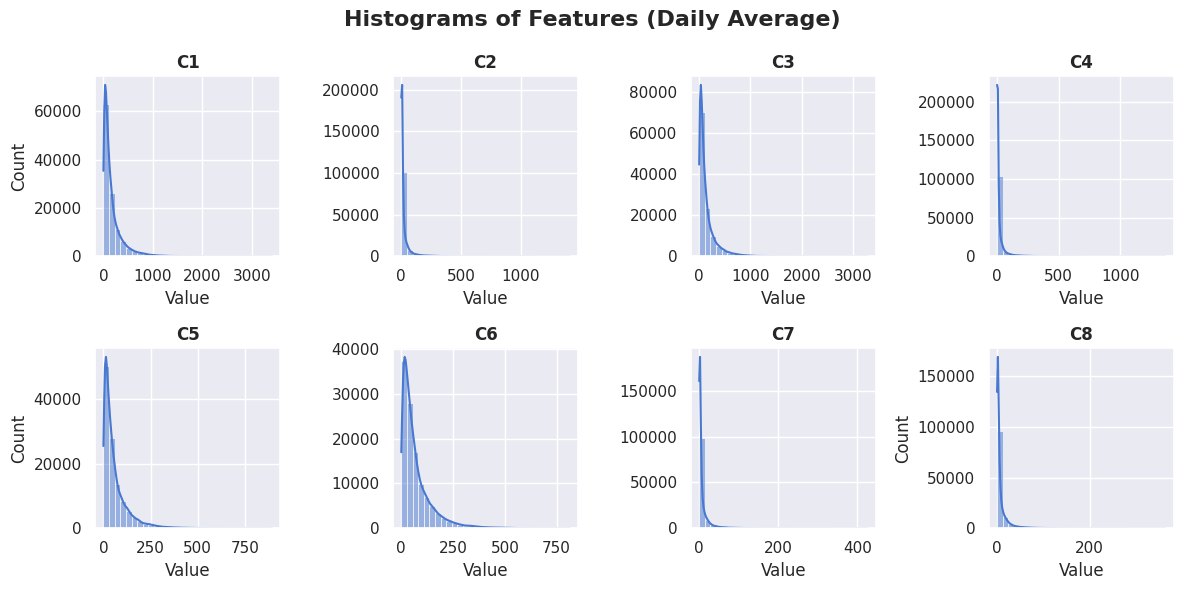

In [17]:
plot_histograms(daily_mean)

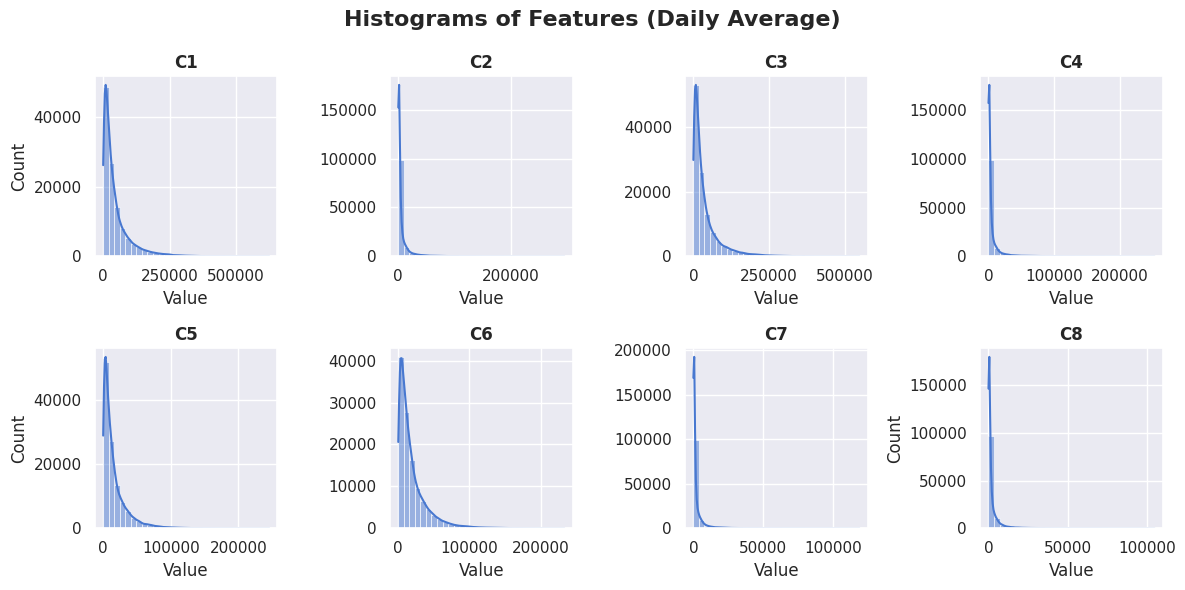

In [18]:
plot_histograms(daily_sum)

Long tails for some of these features! We've also seen that the max value tends to be quite a bit larger than the 99th percetile, there is a possibility that we are dealing with anomalies (i.e. values that are errors). Since we are interested in outliers (values outside of the distribution, but that are real), if we're interested in removing possible anomalies, we have to do so with care, to avoid removing outliers.

Some methods to consider when removing anomalies:
- Interquartile Range (IQR) method: calculate range between quartile 1 and 3 (percentile 25 and 75 respectively), and use that as a "guiding measure". Probably risky in our case since we're dealing with seemingly long tailed distributions.
- Z-score method: calculate the number of standard deviations each data point is away from the mean, and cut-off data points where that value is above a certain threshold. Possible, but using the mean with long tails is probably not the best.
- Modified Z-score: use the median instead of the mean, more robust than the regular Z-score for long tailed distributions (less sensitive to extreme values).
- Isolation Forest: relatively insensitive to the underlying distribution of the data, but more complex to implement.

Given this, a good starting point would be using the modified Z-score method.

### Removing Anomalies

In [5]:
def mad_based_outlier(points, threshold=3.5):
    """
    Identify outliers using the modified Z-score method based on the median absolute deviation (MAD).

    Args:
    points (numpy.array): An array containing the data points.
    threshold (float): The modified Z-score threshold to identify outliers, default is 3.5.

    Returns:
    numpy.array: A boolean array indicating whether each point is an outlier.
    """
    # Calculate the median
    median = np.median(points, axis=0)

    # Calculate the absolute deviation from the median for each data point
    abs_deviation = np.abs(points - median)

    # Calculate the median absolute deviation (MAD)
    mad = np.median(abs_deviation, axis=0)

    # Calculate the modified Z-score using the constant 0.6745
    modified_z_scores = 0.6745 * (abs_deviation / (mad + 1e-6))

    # Identify the outliers using the threshold
    return np.abs(modified_z_scores) > threshold

The value 0.6745 is used to scale the MAD estimator to make it consistent with the standard deviation of a normally distributed dataset. This scaling factor is derived as follows:
1. For a standard normal distribution (mean=0 and std_dev=1), the cumulative distribution function (CDF) at 0.75 is equal to the z-score of 0.6745.
2. In other words, if we have a normally distributed dataset, approximately 75% of the data points lie below the z-score of 0.6745.
3. So, when using the MAD-based modified Z-score, the constant 0.6745 is used to make the estimate consistent with the standard Z-score when the underlying distribution is normal.

What threshold should we use? To calculate that, let's plot the number of data points to consider anomalies versus the threshold.

In [32]:
def count_outliers(dataframe, columns, threshold, grid_id_col='Grid_ID'):
    """
    Count the number of outliers in the dataframe using the modified Z-score method 
    (on a per grid_id basis).

    Args:
    dataframe (pd.DataFrame): The dataframe containing the data.
    columns (List[str]): The columns to count the outliers from.
    threshold (float): The modified Z-score threshold to identify outliers.

    Returns:
    int: The total number of outliers in the specified columns.
    """
    outlier_count = 0
    print(f"Threshold: {threshold}")
    for grid_id in tqdm(dataframe[grid_id_col].unique()):
        grid_data = dataframe[dataframe[grid_id_col] == grid_id]

        for column in columns:
            # Use the mad_based_outlier function to find outliers in the current column
            outliers_mask = mad_based_outlier(grid_data[column].values, threshold)
            outlier_count += np.sum(outliers_mask)

    return outlier_count

Threshold: 1.0


100%|██████████| 3743/3743 [01:33<00:00, 40.23it/s]


Threshold: 2.0


100%|██████████| 3743/3743 [01:34<00:00, 39.68it/s]


Threshold: 3.0


100%|██████████| 3743/3743 [01:31<00:00, 40.79it/s]


Threshold: 4.0


100%|██████████| 3743/3743 [01:14<00:00, 50.31it/s]


Threshold: 5.0


100%|██████████| 3743/3743 [01:15<00:00, 49.28it/s]


Threshold: 6.0


100%|██████████| 3743/3743 [01:16<00:00, 49.09it/s]


Threshold: 7.0


100%|██████████| 3743/3743 [01:15<00:00, 49.39it/s]


Threshold: 8.0


100%|██████████| 3743/3743 [01:15<00:00, 49.52it/s]


Threshold: 9.0


100%|██████████| 3743/3743 [01:16<00:00, 49.18it/s]


Threshold: 10.0


100%|██████████| 3743/3743 [01:16<00:00, 48.94it/s]


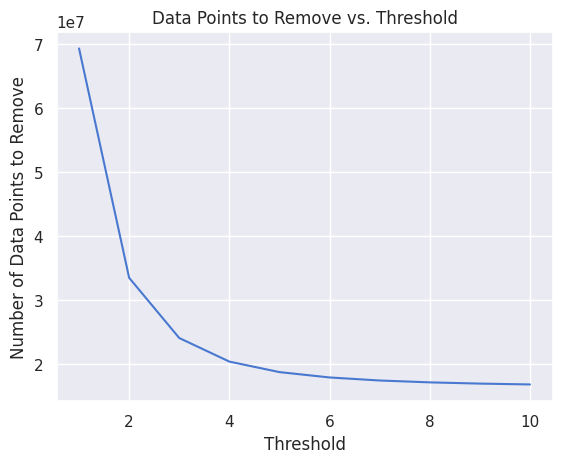

In [31]:
# Relevant features
columns_to_check = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Create a list of thresholds to test
thresholds = np.linspace(1, 10, 10)

# Count the number of outliers for each threshold
outlier_counts = [count_outliers(df_movs, columns_to_check, threshold) for threshold in thresholds]

# Plot the number of data points removed versus the threshold
plt.plot(thresholds, outlier_counts)
plt.xlabel('Threshold')
plt.ylabel('Number of Data Points to Remove')
plt.title('Data Points to Remove vs. Threshold')
plt.show()

To avoid losing outliers, an aggressive approach can be used, by selecting a threshold where, even if the threshold would be bigger, the number of data points to remove would remain relatively the same. Considering that, selecting a threshold of 8 seems to be a good choice, i.e. a point is considered an anomaly if it's an outlier with a distance to the median 8 times higher than the median distance to the median (adjusted with the 0.6745 constant).

In [33]:
# Count the number of outliers using the threshold of 8
outliers_count = count_outliers(df_movs, columns_to_check, threshold=8)

# Calculate the total number of data points in the selected columns
total_data_points = len(df_movs) * len(columns_to_check)

# Calculate the percentage of anomalies
percentage_anomalies = (outliers_count / total_data_points) * 100

print(f"Percentage of values considered anomalies: {percentage_anomalies:.2f}%")

Threshold: 8


100%|██████████| 3743/3743 [01:29<00:00, 41.93it/s]

Percentage of values considered anomalies: 6.96%


This percentage seems a bit high. Let's look at how many of these are isolated outliers, i.e. outliers where both the previous and the afterwards value are not outliers. Random spikes probably have a higher change of being outliers. Semi-isolated outliers are those where at least one of the adjacent data points are not outliers.

In [39]:
def count_isolated_outliers(dataframe, columns, grid_id_col='Grid_ID', threshold=8):
    """
    Count the number of isolated and semi isolated outliers in the dataframe for each Grid_ID.

    Args:
    dataframe (pd.DataFrame): The dataframe containing the data.
    columns (List[str]): The columns to count the isolated outliers from.
    grid_id_col (str): The name of the column containing Grid_ID, default is 'Grid_ID'.
    threshold (float): The modified Z-score threshold to identify outliers, default is 8.

    Returns:
    int: The total number of isolated outliers in the specified columns.
    """
    isolated_outliers_count = 0
    semi_isolated_outliers_count = 0

    for grid_id in dataframe[grid_id_col].unique():
        for column in columns:
            grid_data = dataframe[dataframe[grid_id_col] == grid_id]
            
            # Use the mad_based_outlier function to find outliers in the current column
            outliers_mask = mad_based_outlier(grid_data[column].values, threshold)
            
            for i, is_outlier in enumerate(outliers_mask):
                # Check if the current point is an outlier and not the first or last index
                if is_outlier and 0 < i < len(outliers_mask) - 1:
                    # Check if both previous and next values are not outliers
                    if not (outliers_mask[i - 1] or outliers_mask[i + 1]):
                        isolated_outliers_count += 1
                    if not outliers_mask[i - 1] or not outliers_mask[i + 1]:
                        semi_isolated_outliers_count += 1

    return isolated_outliers_count, semi_isolated_outliers_count

In [40]:
# Count the number of isolated outliers
isolated_outliers_count, semi_isolated_outliers_count = count_isolated_outliers(df_movs, columns_to_check, threshold=8)

# Calculate the percentage of isolated anomalies
percentage_isolated_anomalies = (isolated_outliers_count / total_data_points) * 100
percentage_semi_isolated_anomalies = (semi_isolated_outliers_count / total_data_points) * 100

print(f"Percentage of isolated values considered anomalies: {percentage_isolated_anomalies:.2f}%")
print(f"Percentage of semi-isolated values considered anomalies: {percentage_semi_isolated_anomalies:.2f}%")

Percentage of isolated values considered anomalies: 2.81%
Percentage of semi-isolated values considered anomalies: 5.66%


Considering that a significant percentage of the assumed anomalies ("level 8" outliers) are either isolated or semi-isolated, it seems reasonable to replace those values with interpolated values from the previous and next values.

In [36]:
def replace_outliers_with_custom_interpolation(grid_data, columns, 
                                                  threshold=8):
    """
    Replace outliers in the specified columns of the grid_data dataframe with
    custom interpolation. The custom interpolation logic is as follows:
    1. If both the previous and next data points are not outliers, replace the
       current outlier with the average of the two surrounding data points.
    2. If only the previous data point is not an outlier, replace the current
       outlier with the previous data point value.
    3. If the first value is an outlier, replace it with the nearest non-outlier
       value.

    Parameters:
    grid_data (pd.DataFrame): Dataframe containing the grid data for a single
                              Grid_ID.
    columns (list): List of column names to apply the custom interpolation.
    threshold (float, optional): Threshold for determining outliers.
                                  Defaults to 8.

    Returns:
    None (reduces memory usage)
    """

    def replace_first_last_val(grid_data, z_scores, value):
        """
        Replace either the first or the last value of the grid ID data
        if needed, this is, if z_score is true.
        """
        if value == "first":
            z_sc_ind = 0
            range_start = 1
            direction = 1
        elif value == "last":
            z_sc_ind = -1
            range_start = 2
            direction = -1

        if z_scores[z_sc_ind]:
            for i in range(range_start, len(z_scores)):
                val_ind = direction * i
                if not z_scores[val_ind]:
                    grid_data.loc[grid_data.index[z_sc_ind], column] = (
                        grid_data.loc[grid_data.index[val_ind], column])
                    z_scores[z_sc_ind] = False
                    break
        
        return grid_data, z_scores

    for column in columns:
        # Calculate modified Z-scores
        z_scores = mad_based_outlier(grid_data[column].values, threshold)

        # Check if the first and last value is an anomaly and 
        # replace it with the nearest non-anomaly value
        grid_data, z_scores = replace_first_last_val(grid_data, z_scores, "first")
        grid_data, z_scores = replace_first_last_val(grid_data, z_scores, "last")

        # Create masks for previous, current, and next data points
        # For each data point, we can easily check if it's isolated/semi isolated
        prev_z_scores = np.concatenate(([False], z_scores[:-1]))
        next_z_scores = np.concatenate((z_scores[1:], [False]))

        # Identify cases where both previous and next data points are not outliers
        # This is, Isolated outliers
        # Use .shift to quickly access the previous and next values
        both_not_outliers_mask = np.logical_not(
            np.logical_or(prev_z_scores, next_z_scores))
        
        relevant_idx = (z_scores == True) & both_not_outliers_mask

        grid_data.loc[relevant_idx, column] = ((
            grid_data.loc[:, column].shift(-1) +
            grid_data.loc[:, column].shift(1)) / 2)[relevant_idx]

        # Isolated anomalies have been fixed
        z_scores[(z_scores == True) & both_not_outliers_mask] = False

        # Identify cases where only the previous data point is not an outlier
        prev_not_outlier_mask = np.logical_not(prev_z_scores)

        relevant_idx = (z_scores == True) & prev_not_outlier_mask

        grid_data.loc[relevant_idx, column] = (
            grid_data.loc[:, column].shift(1))[relevant_idx]

        
    return grid_data

In [29]:
def replace_outliers(df, grid_id_col='Grid_ID'):
    for grid_id in df[grid_id_col].unique():
        grid_data = df[df[grid_id_col] == grid_id]
        new_grid_data = replace_outliers_with_custom_interpolation(grid_data,
                                                                   columns_to_check)
        df[df[grid_id_col] == grid_id] = new_grid_data
    return df

In [6]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Day,Month,Weekday
0,1,2022-09-07 12:30:00+00:00,3.69,0.0,3.69,0.0,0.00,5.28,0.0,0.00,12,7,9,2
1,1,2022-09-07 22:30:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,22,7,9,2
2,1,2022-09-07 23:00:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,23,7,9,2
3,1,2022-09-07 18:00:00+00:00,15.72,0.0,10.48,0.0,5.24,6.84,0.0,2.45,18,7,9,2
4,1,2022-09-07 06:30:00+00:00,3.86,0.0,1.93,0.0,3.86,4.43,0.0,0.00,6,7,9,2


In [38]:
grid_data = df_movs[df_movs['Grid_ID'] == 1]

In [43]:
grid_data[0] = 10000
grid_data[-1] = 10000

/tmp/ipykernel_5734/2151157210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data[0] = 10000
/tmp/ipykernel_5734/2151157210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data[-1] = 10000


In [44]:
# Calculate modified Z-scores
z_scores = mad_based_outlier(grid_data["C1"].values, 8)

In [39]:
def replace_first_last_val(grid_data, z_scores, value):
    """
    Replace either the first or the last value of the grid ID data
    if needed, this is, if z_score is true.
    """
    if value == "first":
        z_sc_ind = 0
        range_start = 1
        direction = 1
    elif value == "last":
        z_sc_ind = -1
        range_start = 2
        direction = -1

    if z_scores[z_sc_ind]:
        for i in range(range_start, len(z_scores)):
            val_ind = direction * i
            if not z_scores[val_ind]:
                grid_data.loc[grid_data.index[z_sc_ind], column] = (
                    grid_data.loc[grid_data.index[val_ind], column])
                z_scores[z_sc_ind] = False
                break
    
    return grid_data, z_scores

In [45]:
# Check if the first and last value is an anomaly and 
# replace it with the nearest non-anomaly value
grid_data, z_scores = replace_first_last_val(grid_data, z_scores, "last")

In [46]:
grid_data[0]

0       10000
1       10000
2       10000
3       10000
4       10000
        ...  
2725    10000
2726    10000
2727    10000
2728    10000
2729    10000
Name: 0, Length: 8251, dtype: int64

In [ ]:
# Relevant features
columns_to_check = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

df_movs = replace_outliers(df_movs)

### Ad Hoc Analysis

Which were the days with the highest values? Did anything happen to cause them?

# Temporal EDA

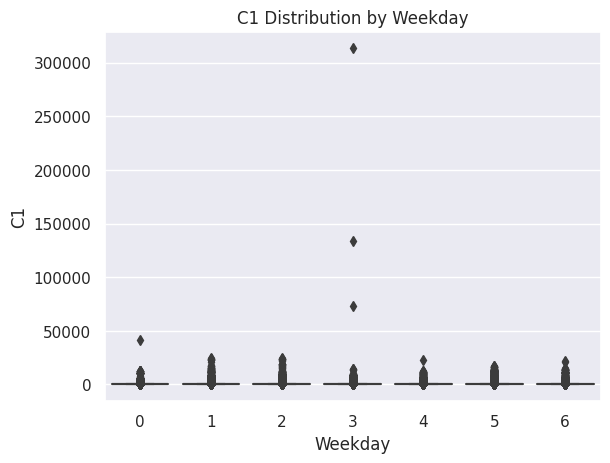

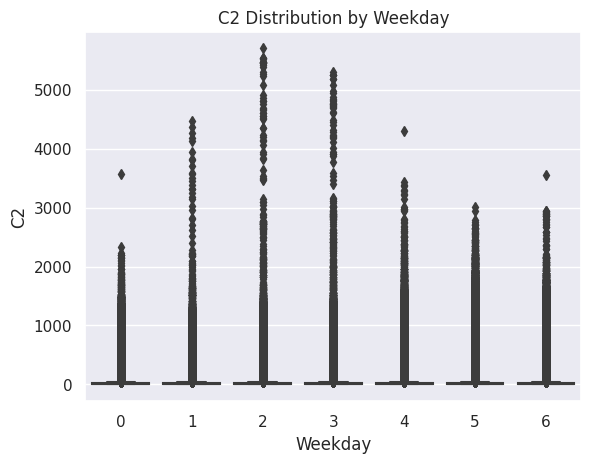

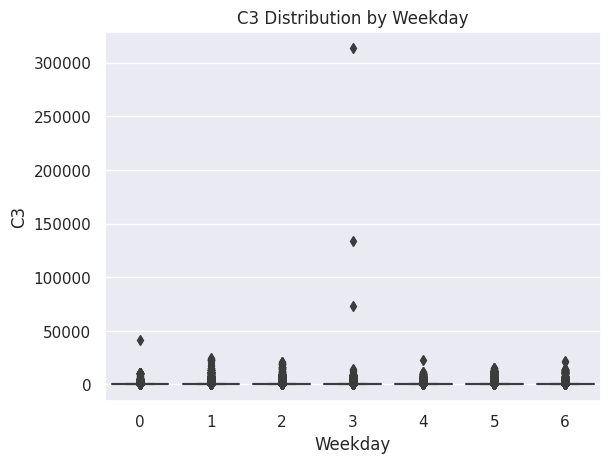

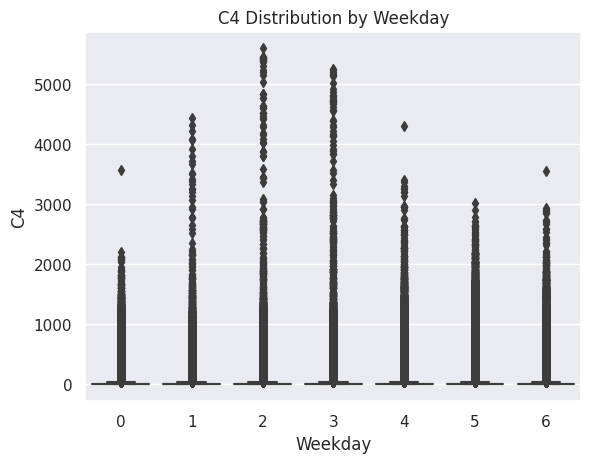

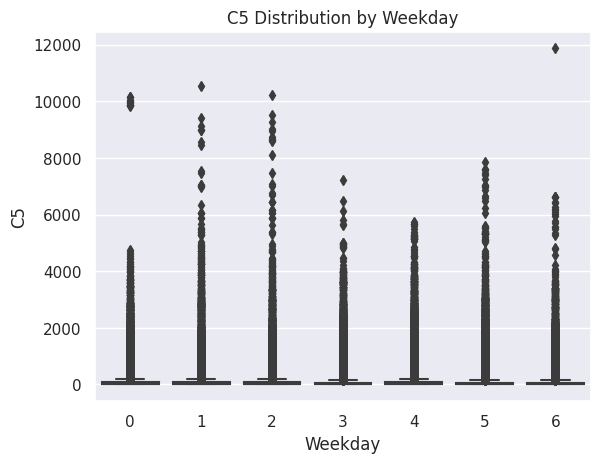

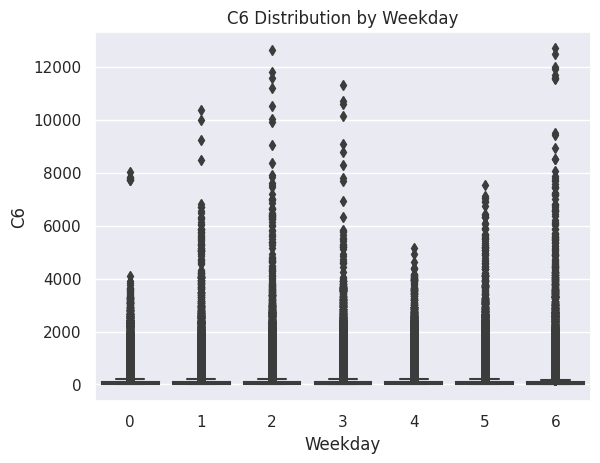

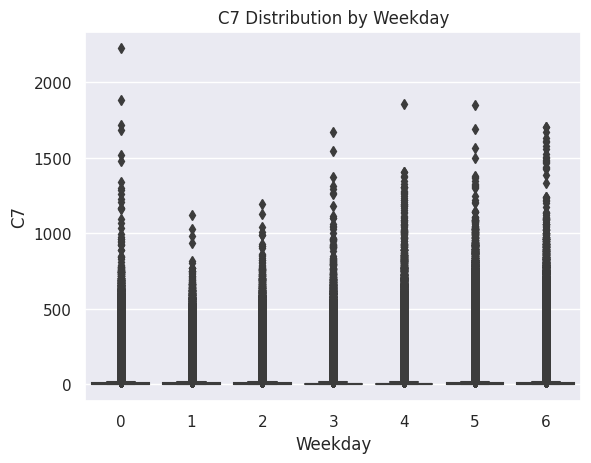

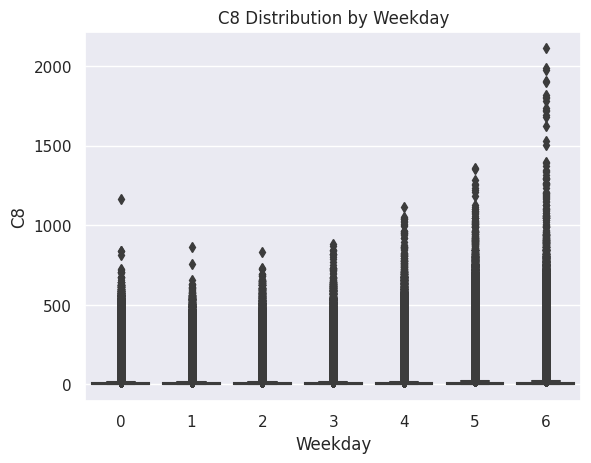

In [41]:
# Create a box plot or violin plot for each feature (C1 to C8)
for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']:
    plt.figure()
    sns.boxplot(x='Weekday', y=col, data=df_movs)
    # Optionally, use violin plot instead of box plot
    # sns.violinplot(x='Weekday', y=col, data=df)
    plt.title(f'{col} Distribution by Weekday')
    plt.show()

# Spatial EDA

In [ ]:
hourly_mean = df_movs.groupby(['Grid_ID', 'Hour']).mean().reset_index()

In [56]:
hourly_mean.head()

,Grid_ID,Hour,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Day,Month,Weekday
0,1,0,2022-10-14 18:40:07.826086912+00:00,2.388290,0.252464,2.126638,0.238290,0.577159,0.703449,0.050203,0.029304,15.223188,9.973913,3.037681
1,1,1,2022-10-14 21:11:20.232558336+00:00,2.515116,0.224855,2.299273,0.196395,0.906686,0.491483,0.037500,0.029128,15.197674,9.976744,3.034884
2,1,2,2022-10-14 22:11:20.232558336+00:00,3.407296,0.163808,3.097733,0.154157,0.489360,0.405901,0.044797,0.008634,15.197674,9.976744,3.034884
3,1,3,2022-10-15 04:26:31.691394816+00:00,4.577597,0.247448,4.366944,0.241395,0.982908,0.339496,0.065875,0.021306,15.068249,9.988131,3.008902
4,1,4,2022-10-15 04:22:30+00:00,3.380060,0.262530,3.314315,0.248869,0.545506,0.355179,0.013661,0.015565,15.023810,9.988095,3.000000


In [57]:
# Pivot the result to have hours as columns for c1
c1_hourly_mean_pivot = hourly_mean.pivot_table(values='C1', index='Grid_ID', columns='Hour').reset_index()

In [79]:
c1_hourly_mean_pivot.head()

Hour,Grid_ID,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,2.388290,2.515116,3.407296,4.577597,3.380060,3.141707,2.832411,3.852946,2.574107,...,5.427384,5.291347,5.899186,5.584323,4.741149,3.584684,3.400684,3.808977,2.785739,2.897213
1,2,3.599652,3.002180,2.109070,1.784451,2.665476,2.491138,3.898690,5.021131,5.063393,...,8.998517,8.947736,12.492267,8.833112,5.567902,5.030115,4.611880,3.405057,4.759432,4.775603
2,3,3.013768,2.471919,2.112442,2.459139,3.126667,3.644311,5.829048,7.880595,9.194821,...,15.788546,13.695444,20.755785,17.321614,10.579569,9.909540,7.013989,6.147955,6.315057,4.810144
3,4,3.778754,3.497907,3.481744,3.747389,3.360208,3.031317,3.488542,5.453631,8.042202,...,19.672326,16.608052,15.678721,13.889251,10.985172,9.726494,7.370541,8.819432,4.752983,3.967931
4,5,15.694638,16.703517,15.888605,13.346577,14.437054,15.207754,16.931994,17.432500,16.878988,...,37.608023,34.410630,32.866337,31.271902,25.144828,20.498649,17.323248,15.146733,14.183153,14.680115


In [87]:
# Merge the grid geometry and hourly average values;
# This will create a dataframe that has (besides other things) the grid id,
# the grid_id geometry, and the values for C1 from hour 0 to hour 23 (average of the 3 months)
grid_gdf = grid_gdf.merge(c1_hourly_mean_pivot, on='Grid_ID')

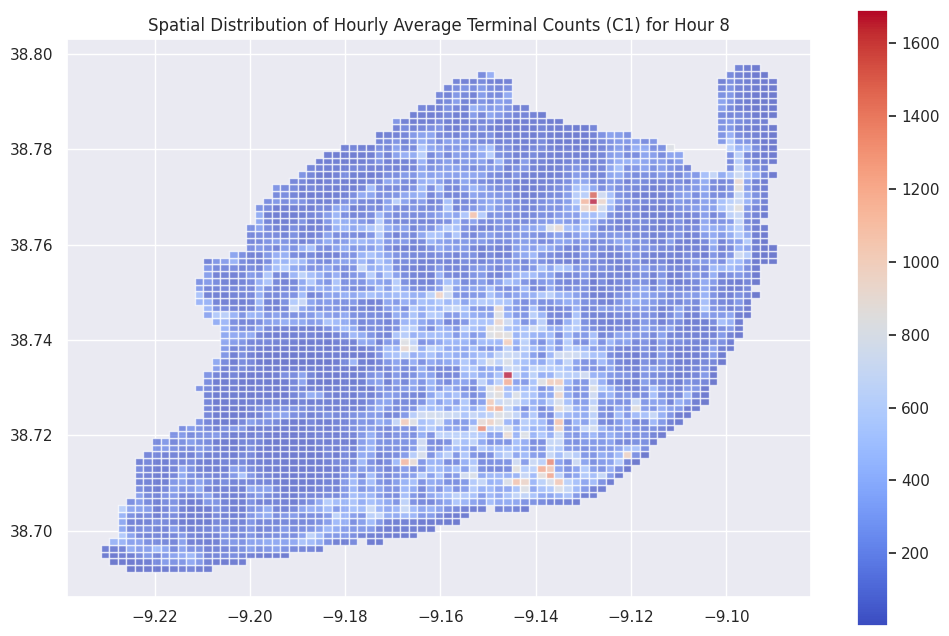

In [99]:
# Plot the C1 values for a specific hour (e.g., hour 12)
hour_to_plot = 8
fig, ax = plt.subplots(figsize=(12, 8))
grid_gdf.plot(column=hour_to_plot, cmap='coolwarm', legend=True, alpha=0.7, ax=ax)
plt.title(f'Spatial Distribution of Hourly Average Terminal Counts (C1) for Hour {hour_to_plot}')
plt.show()

In [113]:
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

/tmp/ipykernel_8321/2226878670.py:20: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


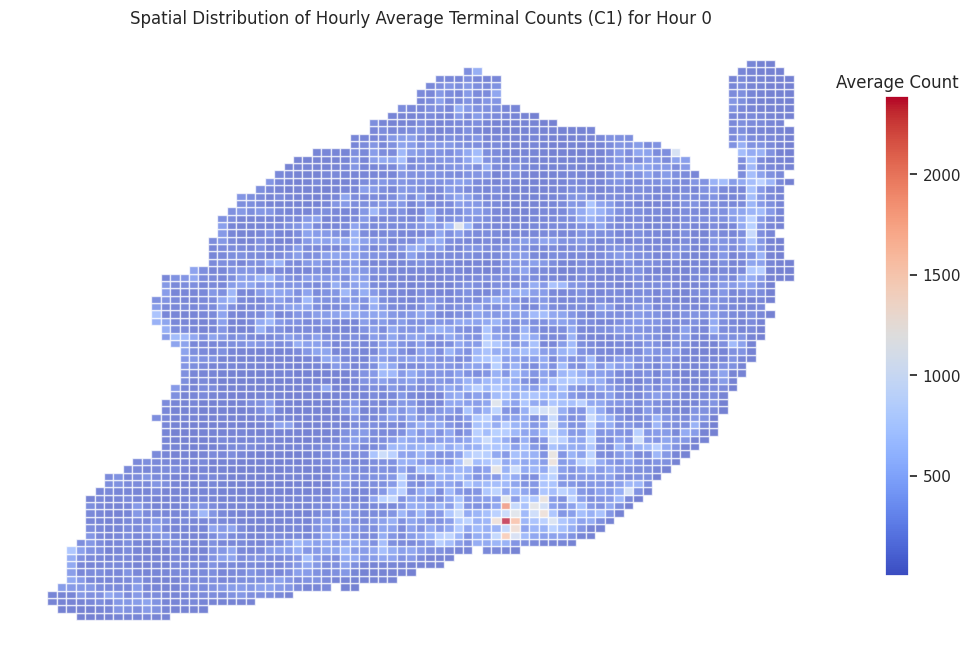

In [112]:
# Create the animation with a single axis for the map
def create_animation():
    fig, ax_map = plt.subplots(figsize=(12, 8))
    cax = fig.add_axes([0.90, 0.2, 0.02, 0.6])  # Adjust the parameters to fit the colorbar inside the GIF
    colorbar_added = False

    def init():
        return update_heatmap(0),

    def update_heatmap(hour):
        nonlocal colorbar_added

        ax_map.clear()

        plot = grid_gdf.plot(column=hour, cmap='coolwarm', alpha=0.7, ax=ax_map)

        if not colorbar_added:
            cbar = fig.colorbar(plot.get_children()[0], cax=cax)
            cbar.set_alpha(1)
            cbar.draw_all()
            cax.set_title("Average Count")
            colorbar_added = True

        ax_map.set_title(f'Spatial Distribution of Hourly Average Terminal Counts (C1) for Hour {hour}')
        ax_map.set_axis_off()

        return ax_map,

    ani = animation.FuncAnimation(fig, update_heatmap, frames=range(0, 24), init_func=init, interval=1000, blit=False)
    return ani

# Create the animation
ani = create_animation()

# Save the animation as a GIF
ani.save('hourly_heatmap_animation.gif', writer=PillowWriter(fps=1))

What are the areas with higher activity?
Any reason why they have the highest activity?
What are the main roads/monuments/stadiums/points of interest, and how are they in the map?